In [2]:
from adaptive_rag.utils import tools, safeguard, search, generate, memory, mongoDB, router, slang, state, check
from adaptive_rag.utils.state import AdaptiveRagState
from typing import TypedDict, List
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from functools import partial
import random
import threading
import sys
from typing import Dict, Any, Union # Added Union

# 툴 설정 함수
# 툴 설정 함수
def set_tools():
    """
    Set up the tools for the Adaptive RAG pipeline.
    """
    tools_list = [
        tools.search_policy,
        tools.search_admission,
        tools.search_book,
        tools.search_subject,
        tools.search_seteuk
    ]
    
    return tools_list

# 툴 설정
tools = set_tools()

def build_adaptive_rag() -> StateGraph:
    builder = StateGraph(AdaptiveRagState)
    builder.set_entry_point("profanity_prevention")

    builder.add_node("profanity_prevention", partial(safeguard.profanity_prevention))
    builder.add_node("route_question_adaptive", router.route_question_adaptive)
    builder.add_node("re_route_question_adaptive", router.re_route_question_adaptive)
    builder.add_node("check_relevance", check.check_relevance)

    # Search nodes
    builder.add_node("search_policy", search.search_policy_adaptive)
    builder.add_node("search_subject", search.search_subject_adaptive)
    builder.add_node("search_admission", search.search_admission_adaptive)
    builder.add_node("search_book", search.search_book_adaptive)
    builder.add_node("search_seteuk", search.search_seteuk_adaptive)

    # Generate & fallback
    builder.add_node("generate", generate.generate_adaptive)
    builder.add_node("llm_fallback", generate.llm_fallback_adaptive)

    # Step 1: 욕설 체크
    builder.add_conditional_edges(
        "profanity_prevention",
        safeguard.check_profanity_result,
        {"__end__": "__end__", "route_question_adaptive": "route_question_adaptive"}
    )

    # Step 2: 첫 라우팅 → search로
    builder.add_conditional_edges(
        "route_question_adaptive",
        lambda state: state["next_node"],
        {
            "search_policy": "search_policy",
            "search_subject": "search_subject",
            "search_admission": "search_admission",
            "search_book": "search_book",
            "search_seteuk": "search_seteuk",
            "llm_fallback": "llm_fallback",
        }
    )

    # Step 3: search 결과 → check relevance
    for node in ["search_policy", "search_subject", "search_admission", "search_book", "search_seteuk"]:
        builder.add_edge(node, "check_relevance")
        

    builder.add_conditional_edges(
        "check_relevance",
        lambda state: (
            "generate"
            if state.get("relevance_score") == 1
            else (
                "re_route_question_adaptive"
                if not state.get("retried", False)
                else "llm_fallback"
            )
        ),
        {
            "generate": "generate",
            "re_route_question_adaptive": "re_route_question_adaptive",
            "llm_fallback": "llm_fallback",
        }
    )

    builder.add_conditional_edges(
        "re_route_question_adaptive",
        lambda state: (
            "llm_fallback"
            if state["next_node"] in state.get("visited_nodes", [])
            else state["next_node"]
        ),
        {
            "search_policy": "search_policy",
            "search_subject": "search_subject",
            "search_admission": "search_admission",
            "search_book": "search_book",
            "search_seteuk": "search_seteuk",
            "llm_fallback": "llm_fallback",
        }
    )


    # Step 6: generate / fallback 종료 처리
    builder.add_edge("generate", "__end__")
    builder.add_edge("llm_fallback", "__end__")

    return builder.compile()

def run_chatbot():
    graph = build_adaptive_rag()
    user_id = random.randint(1, 1_000_000)

    def timeout_exit():
        print("\n5분 동안 입력이 없어 챗봇을 종료합니다.")
        sys.exit(0)

    timer = threading.Timer(300, timeout_exit)
    timer.start()

    try:
        while True:
            question = input("질문을 입력해주세요 > ").strip()
            timer.cancel()
            if not question:
                print("종료합니다.")
                break

            inputs = {
                "question": question,
                "user_id": user_id,
                "category": None
            }

            for output in graph.stream(inputs):
                print("\n🔁 [STEP OUTPUT]")
                for node_name, state in output.items():
                    print(f"🔗 question: {state.get('question')}")
                    print(f"📍 Node: {node_name}")
                    print(f"🧠 next_node: {state.get('next_node')}")
                    print(f"🧩 prompt_key: {state.get('prompt_key')}")
                    print(f"🧭 visited_nodes: {state.get('visited_nodes')}")
                    print(f"🔍 relevance_score: {state.get('relevance_score')}")

                    docs = state.get("documents", [])
                    if docs:
                        print("📄 검색된 문서 요약:")
                        for i, doc in enumerate(docs[:3]):
                            content = doc.page_content.strip().replace('\n', ' ')
                            print(f"  [{i+1}] {content[:200]}...")
                    else:
                        print("📄 검색된 문서 없음")

                    if "generation" in state:
                        print(f"\n🤖 답변: {state['generation']}")

                    final_output = state

            timer = threading.Timer(300, timeout_exit)
            timer.start()

    finally:
        timer.cancel()

c:\Users\82106\college-admission-chatbot\chatbot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu
c:\Users\82106\college-admission-chatbot\chatbot\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [3]:
# 챗봇 실행
if __name__ == "__main__":
    print("챗봇을 시작합니다. 질문을 입력해주세요.")
    run_chatbot()

챗봇을 시작합니다. 질문을 입력해주세요.

🔁 [STEP OUTPUT]
🔗 question: 안녕
📍 Node: profanity_prevention
🧠 next_node: None
🧩 prompt_key: None
🧭 visited_nodes: None
🔍 relevance_score: None
📄 검색된 문서 없음

🔁 [STEP OUTPUT]
🔗 question: 안녕
📍 Node: route_question_adaptive
🧠 next_node: llm_fallback
🧩 prompt_key: llm_fallback
🧭 visited_nodes: ['llm_fallback']
🔍 relevance_score: None
📄 검색된 문서 없음


C:\Users\82106\college-admission-chatbot\adaptive_rag\utils\memory.py:23: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory_store[user_id] = ConversationBufferWindowMemory(



🔁 [STEP OUTPUT]
🔗 question: 안녕
📍 Node: llm_fallback
🧠 next_node: llm_fallback
🧩 prompt_key: llm_fallback
🧭 visited_nodes: ['llm_fallback']
🔍 relevance_score: None
📄 검색된 문서 없음

🤖 답변: 안녕하세요! 😊 궁금한 점이 있다면 언제든지 물어봐 주세요!

🔁 [STEP OUTPUT]
🔗 question: 세특에 수상실적도 적을 수 있어?
📍 Node: profanity_prevention
🧠 next_node: None
🧩 prompt_key: None
🧭 visited_nodes: None
🔍 relevance_score: None
📄 검색된 문서 없음


C:\Users\82106\college-admission-chatbot\adaptive_rag\utils\router.py:119: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output = tool_map[tool_name](question)  # 여기에 실제 검색 결과가 담김



🔁 [STEP OUTPUT]
🔗 question: 세부능력 및 특기사항에 수상 실적도 적을 수 있어?
📍 Node: route_question_adaptive
🧠 next_node: search_policy
🧩 prompt_key: policy
🧭 visited_nodes: ['search_policy']
🔍 relevance_score: None
📄 검색된 문서 없음

🔁 [STEP OUTPUT]
🔗 question: 세부능력 및 특기사항에 수상 실적도 적을 수 있어?
📍 Node: search_policy
🧠 next_node: search_policy
🧩 prompt_key: policy
🧭 visited_nodes: ['search_policy']
🔍 relevance_score: None
📄 검색된 문서 요약:
  [1] 여도 및 태도 등 2.  전문  교과의  전공  실무 과목  : 능력단위별 학습활동 참여도 및 태도 등 ⑤ '과목별 세부능력 및 특기사항'은 모든 교과(군)의 모든 학생을 대상으로 입력한다. ⑥ 고등학교의 보통 교과 중 교양 교과는 과목명 및 학점을 입력하고, '이수여 부'란에는 'P'를 입력한다. ⑦  '②'항에  따라  석차등급을  산출하는  과목  중...
  [2] [학생부 기재금지 내용] (2024학년도 기준) ※ 교육부(2024), 2024학년도 학교생활기록부 기재요령 - 가 . 각종 공인어학시험 참여 사실과 그 성적 및 수상실적 - 나 . 교과·비교과 관련 교외대회 참여 사실과 그 성적 및 수상실적 - 다 . 교외 기관단체장 등에게 수상한 교외상(표창장, 감사장, 공로상 등 기재불가) - 라 . 교내외 인증시험 ...
  [3] 다 과목별 세부능력 및 특기사항이 왜 중요한가요? - ・  대학입학전형에서 학교생활기록부의 미반영 항목이 증가하고 자기소개서 및 교사추천서가 폐지된 상황에서 가장 중요한 것이 과목별 세부능력 및 특기사항입니다. - ・     과목별 세부능력 및 특기사항은 모든 교과 담당 교사가 모든 학생을 대상

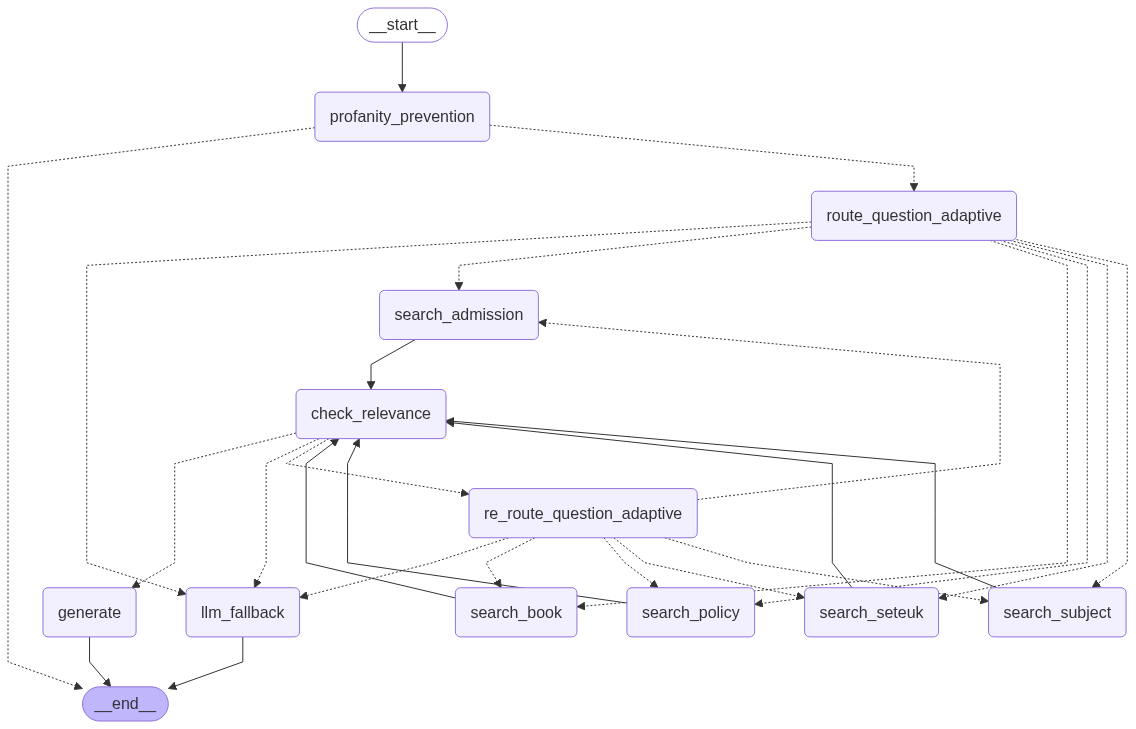

In [7]:
from IPython.display import Image, display

graph = build_adaptive_rag()
# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png(max_retries=10, retry_delay=2.0)))